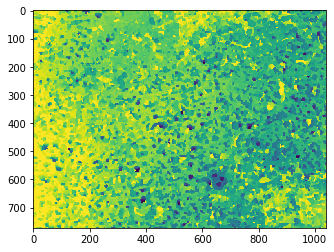

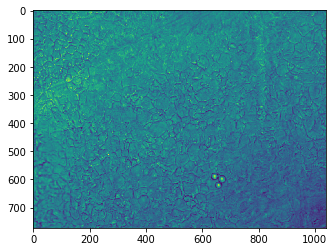

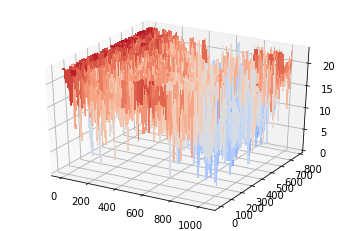

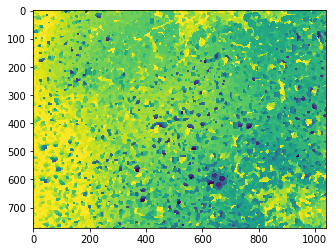

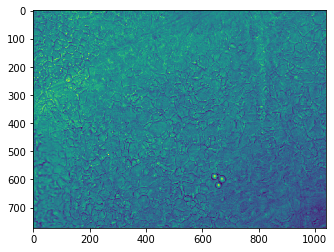

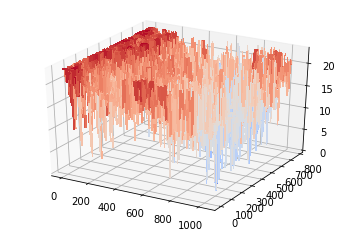

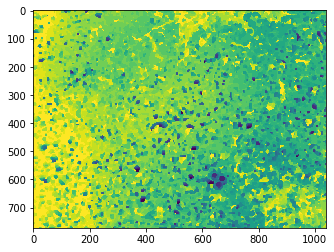

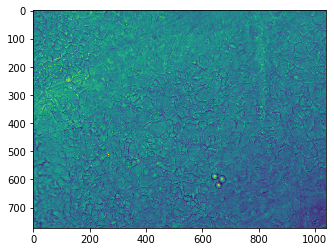

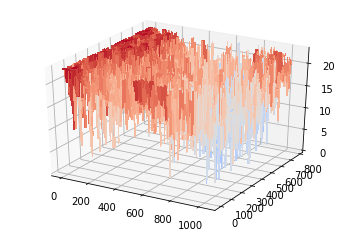

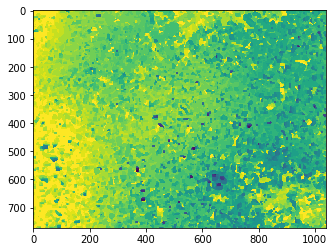

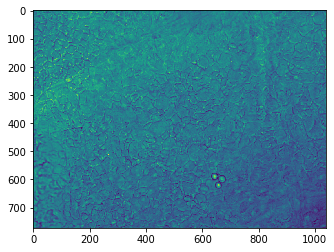

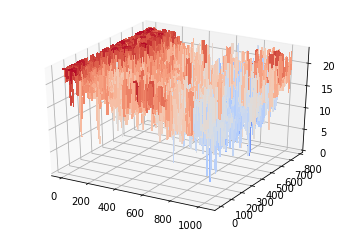

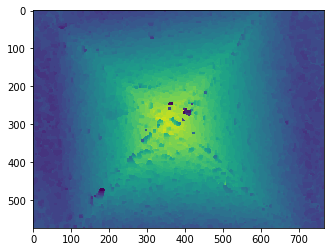

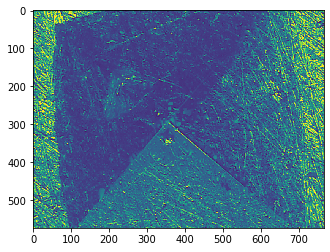

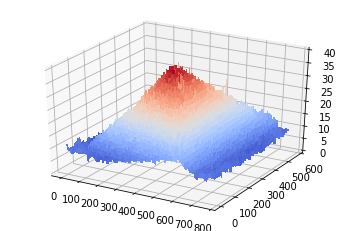

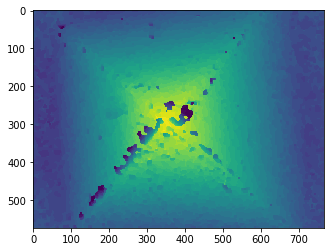

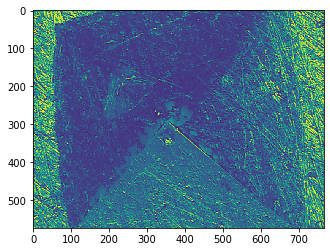

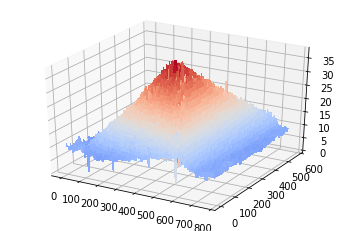

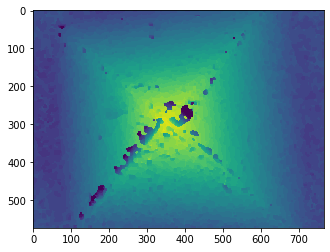

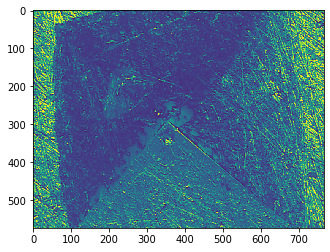

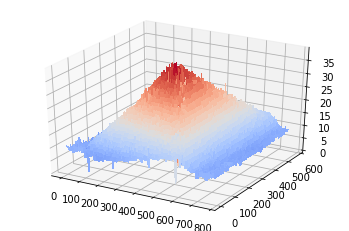

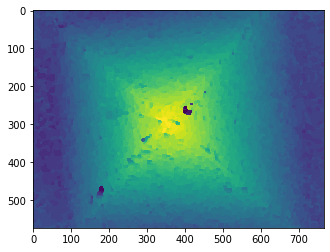

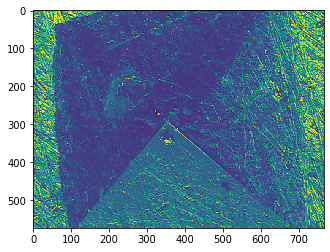

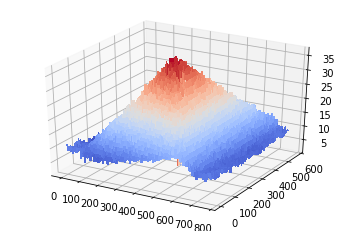

In [3]:
%matplotlib inline
"""
Created on Thu Mar 15 16:54:12 2018

@author: yann
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from scipy import ndimage
from matplotlib import cm


def extractTexture(I, Z):
    """
    Extract texture from stack of images I, where Z is the index (altitude)
    I: stack of images, of shape (n, X, Y)
    Z: index of SFF maximum (of shape (X,Y)), values are between 0 and n-1
    returns basically I[Z(i,j], i, j)] for all (i,j)
    """
    m, n = I.shape[1:]
    ii, jj = np.ogrid[:m, :n]
    T = I[Z, ii, jj]
    return T


def variance(I, N):
    """
    SFF measure
    I: image
    N: neighborhood size
    returns: SFF measure for each pixel, results is the same shape as I
    """
    M = ndimage.uniform_filter(I, N)
    D2 = (I - M) ** 2
    V = ndimage.uniform_filter(D2, N)
    return V


def tenengrad(I, N):
    """
    SFF measure, Tenengrad method
    I: image
    N: neighborhood size
    returns: SFF measure for each pixel, results is the same shape as I
    """
    Sx = ndimage.sobel(I, axis=0)
    Sy = ndimage.sobel(I, axis=1)
    S = np.hypot(Sx, Sy)
    T = ndimage.uniform_filter(S, N)
    return T


def varianceTenengrad(I, N):
    """
    SFF measure, variance of Tenengrad
    I: image
    N: neiborhood size
    returns: SFF measure for each pixel
    """
    Sx = ndimage.sobel(I, axis=0)
    Sy = ndimage.sobel(I, axis=1)
    S = np.hypot(Sx, Sy)
    vt = variance(S, N)
    return vt


def sml(I, N):
    """
    SFF measure, SUM of modified Laplacian
    I: image
    N: neiborhood size
    returns: SFF measure for each pixel
    """
    ML = np.abs(ndimage.sobel(I, axis=0)) + np.abs(ndimage.sobel(I, axis=1))
    S = ndimage.uniform_filter(ML, N)
    return S


###############################################################################
# %%
# loops through the different volumes, the different functions
volumes = ['cornee', 'vickers']
for v in volumes:
    I = io.imread('volume_'+v+'.tif')
    I = I.astype('float')
    F = np.zeros(I.shape)
    N = 11

    myfunctions = [variance, tenengrad, sml, varianceTenengrad]
    for f in myfunctions:
        for i, im in enumerate(I):
            F[i] = f(im, N)

        # Evaluates altitudes and textures
        Z = np.argmax(F, axis=0)
        Z = ndimage.minimum_filter(Z, size=5)
        T = extractTexture(I, Z)

        # Display and stores results
        plt.figure()
        plt.imshow(Z)
        plt.show()
        plt.imshow(T)
        plt.show()
        plt.imsave(f.__name__+"_"+v+"_altitudes.png", Z, cmap='gray')
        plt.imsave(f.__name__+"_"+v+"_texture.png", T, cmap='gray')

        # surface
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        s = I.shape
        X, Y = np.meshgrid(range(s[2]), range(s[1]))
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)
        fig.savefig(f.__name__+"_"+v+"_surf.png", bbox_inches='tight', dpi=300)